In [1]:
# !pip install torchviz

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
from torchviz import make_dot

In [4]:
import scanpy as sc

In [5]:
data_left=pd.read_csv('DATA/gex_input_824_hvf.csv.gz').set_index('Unnamed: 0')
data_left.shape

(5220, 824)

In [6]:
data_right=pd.read_csv('DATA/atac_input_3024_hvf.csv.gz').set_index('Unnamed: 0')
# data_right

In [7]:
data_left=pd.read_csv('DATA/gex_input_824_hvf.csv.gz').set_index('Unnamed: 0')
data_left.shape
x_train_left=torch.tensor(data_left.values,dtype=torch.float32)
x_train_right=torch.tensor(data_right.values,dtype=torch.int8)

# Data Loader

In [10]:
from torch.utils.data import Dataset, DataLoader

class PairedDataset(Dataset):
    def __init__(self, data1,data2,labels):
        self.data1=data1
        self.data2=data2
        self.labels=labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,index):
        return self.data1[index],self.data2[index],self.labels[index]
paired_dataset=PairedDataset(x_train_left,x_train_right,data_left.index)
paired_data_loader=DataLoader(dataset=paired_dataset,batch_size=256,shuffle=True)

# Model, train step & custom loss

In [11]:
from splitvae import VAE, recon_kld_loss, train_step

input_dim=824
hidden_dim=256
hidden_dim2=512
latent_dim=64
right_output_dim=3024
vae=VAE(input_dim,hidden_dim,hidden_dim2,latent_dim,right_output_dim)
optimizer=optim.Adam(vae.parameters())

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(4,4)

# Train Loop

In [13]:
import numpy as np
batch_size=256
epochs=10000
min_loss=np.Inf
last_loss_update=0
for epoch in range(epochs):
    for batch_data_left,batch_data_right,batch_labels in paired_data_loader:
#         batch_data_left=x_train_left[batch_start:batch_start+batch_size]
#         batch_data_right=x_train_right[batch_start:batch_start+batch_size]
        loss=train_step(vae,batch_data_left,batch_data_right,optimizer)
    if loss< min_loss:
        min_loss=loss
        last_loss_update=0
    else:
        last_loss_update+=1
    if last_loss_update>=20:
        print('No loss improvment in 10 epochs')
        break
    if epoch%10==0:
        print('Epoch: '+str(epoch), 'Loss: '+str(loss))

Epoch: 0 Loss: 96.73046875
Epoch: 10 Loss: 92.1253662109375
Epoch: 20 Loss: 84.51640319824219
Epoch: 30 Loss: 85.58168029785156
Epoch: 40 Loss: 85.68523406982422
Epoch: 50 Loss: 85.71088409423828
Epoch: 60 Loss: 80.7824935913086
Epoch: 70 Loss: 79.39826965332031
Epoch: 80 Loss: 80.9590072631836
Epoch: 90 Loss: 80.25608825683594
Epoch: 100 Loss: 77.58480072021484
Epoch: 110 Loss: 79.85429382324219
Epoch: 120 Loss: 76.99015045166016
Epoch: 130 Loss: 76.46562194824219
Epoch: 140 Loss: 77.60873413085938
Epoch: 150 Loss: 76.72074890136719
Epoch: 160 Loss: 76.89573669433594
Epoch: 170 Loss: 76.97093200683594
No loss improvment in 10 epochs


In [14]:
batch_data_right.shape

torch.Size([100, 3024])

In [15]:
batch_data_left.shape

torch.Size([100, 824])

In [16]:
len(paired_dataset)

5220

In [17]:
print(len([batch_data_left,batch_data_right,batch_labels in paired_dataset]))

3


# Achieving lower loss without data loader, overfitting?

In [18]:
import numpy as np
batch_size=256
epochs=10000
min_loss=np.Inf
last_loss_update=0
for epoch in range(epochs):
    for batch_start in range(0,len(x_train_left),batch_size):
        batch_data_left=x_train_left[batch_start:batch_start+batch_size]
        batch_data_right=x_train_right[batch_start:batch_start+batch_size]
        loss=train_step(vae,batch_data_left,batch_data_right,optimizer)
    if loss< min_loss:
        min_loss=loss
        last_loss_update=0
    else:
        last_loss_update+=1
    if last_loss_update>=10:
        print('No loss improvment in 10 epochs')
        break
    if epoch%10==0:
        print('Epoch: '+str(epoch), 'Loss: '+str(loss))

Epoch: 0 Loss: 76.2812271118164
Epoch: 10 Loss: 71.69805908203125
Epoch: 20 Loss: 68.81153869628906
Epoch: 30 Loss: 67.73112487792969
Epoch: 40 Loss: 65.55509185791016
Epoch: 50 Loss: 63.08253479003906
Epoch: 60 Loss: 61.59744644165039
Epoch: 70 Loss: 60.36851119995117
Epoch: 80 Loss: 59.62539291381836
Epoch: 90 Loss: 58.591514587402344
Epoch: 100 Loss: 57.456298828125
Epoch: 110 Loss: 56.81159591674805
Epoch: 120 Loss: 56.36381530761719
Epoch: 130 Loss: 55.32929611206055
Epoch: 140 Loss: 55.09746170043945
Epoch: 150 Loss: 54.65367889404297
Epoch: 160 Loss: 53.580413818359375
Epoch: 170 Loss: 53.45441436767578
Epoch: 180 Loss: 52.82930374145508
Epoch: 190 Loss: 52.301753997802734
Epoch: 200 Loss: 52.20063781738281
Epoch: 210 Loss: 51.63970184326172
Epoch: 220 Loss: 51.54104995727539
Epoch: 230 Loss: 51.08014678955078
Epoch: 240 Loss: 51.16804504394531
No loss improvment in 10 epochs


In [21]:
recon_gex,generated_sample,_,_=vae(x_train_left)
output=vae(x_train_left)

# Model Diagram

In [22]:
# dot = make_dot(output, params=dict(vae.named_parameters()))
# dot.render("model_graph", format="png")

In [23]:
# import matplotlib.pyplot as plt
# from PIL import Image

# # Open and display the saved image
# img = Image.open("model_graph.png")
# plt.imshow(img)
# plt.show()

In [24]:
recon_gex=recon_gex.detach().numpy()

In [25]:
from scanpy import AnnData

In [26]:
adata=AnnData(data_left)
gdata=AnnData(pd.DataFrame(recon_gex))
gdata.obs.index=adata.obs.index
gdata.var.index=adata.var.index

# Original and reconstructed GEX data

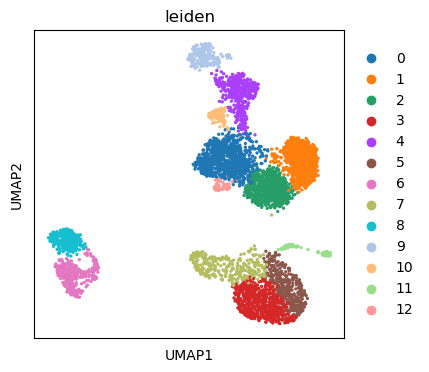

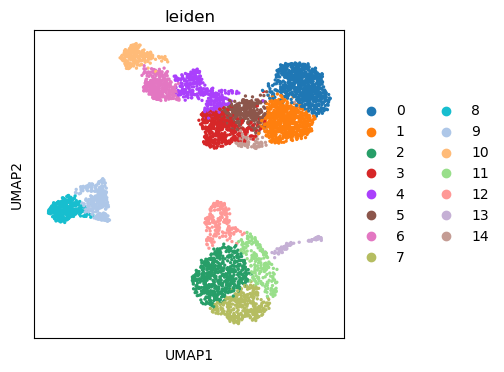

In [27]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color='leiden')
sc.tl.pca(gdata)
sc.pp.neighbors(gdata)
sc.tl.leiden(gdata)
sc.tl.umap(gdata)
sc.pl.umap(gdata,color='leiden')

In [28]:
cdata=adata.concatenate(gdata)

# Integrated original and recon data (no batch correction)

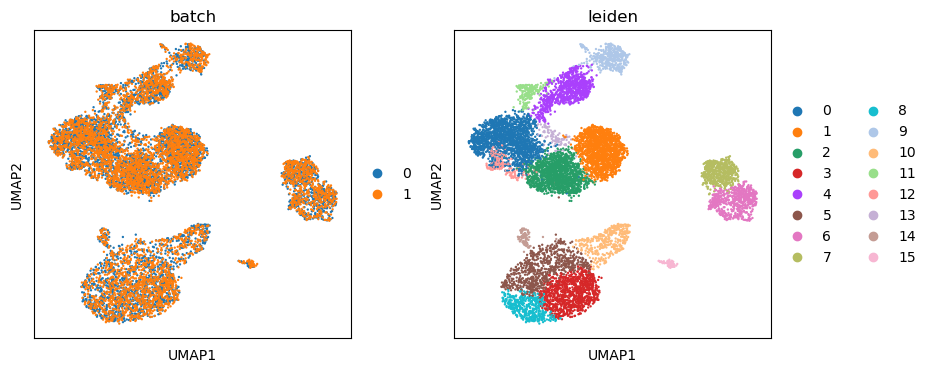

In [29]:
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata,color=['batch','leiden'])

# GEX integrated and recon data (with batch correction)

2025-01-31 14:16:53,827 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-31 14:16:56,301 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-31 14:16:56,354 - harmonypy - INFO - Iteration 1 of 20
2025-01-31 14:16:58,400 - harmonypy - INFO - Iteration 2 of 20
2025-01-31 14:17:00,479 - harmonypy - INFO - Iteration 3 of 20
2025-01-31 14:17:02,538 - harmonypy - INFO - Iteration 4 of 20
2025-01-31 14:17:04,599 - harmonypy - INFO - Iteration 5 of 20
2025-01-31 14:17:06,707 - harmonypy - INFO - Iteration 6 of 20
2025-01-31 14:17:08,645 - harmonypy - INFO - Iteration 7 of 20
2025-01-31 14:17:09,347 - harmonypy - INFO - Iteration 8 of 20
2025-01-31 14:17:10,050 - harmonypy - INFO - Converged after 8 iterations


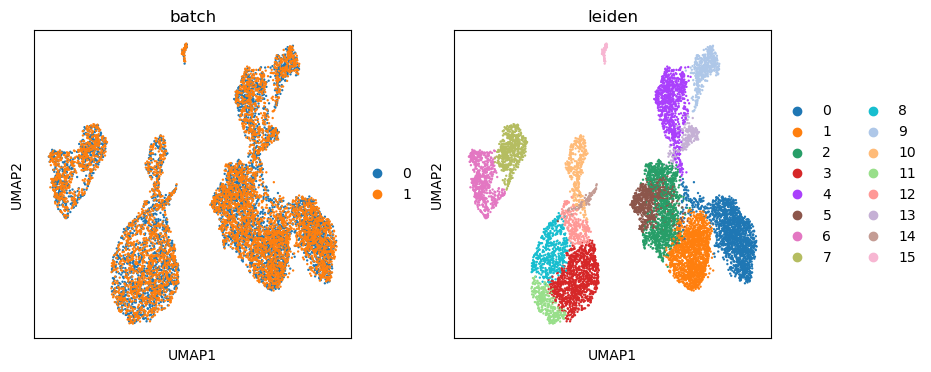

In [30]:
sc.external.pp.harmony_integrate(cdata, 'batch',max_iter_harmony=20)
sc.pp.neighbors(cdata,n_pcs=20,n_neighbors=20,use_rep='X_pca_harmony')
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata,color=['batch','leiden'])

# Original ATAC, reconstructed ATAC, & integrated ATAC (with and without BC)

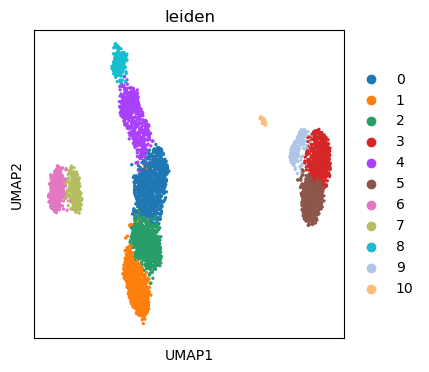

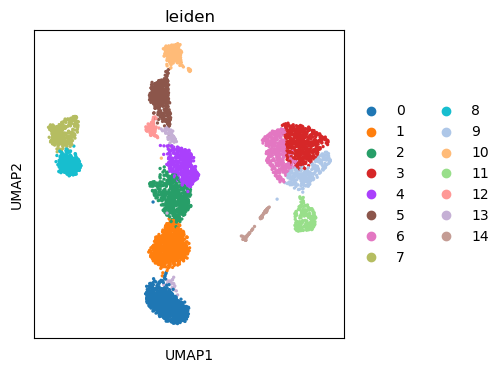

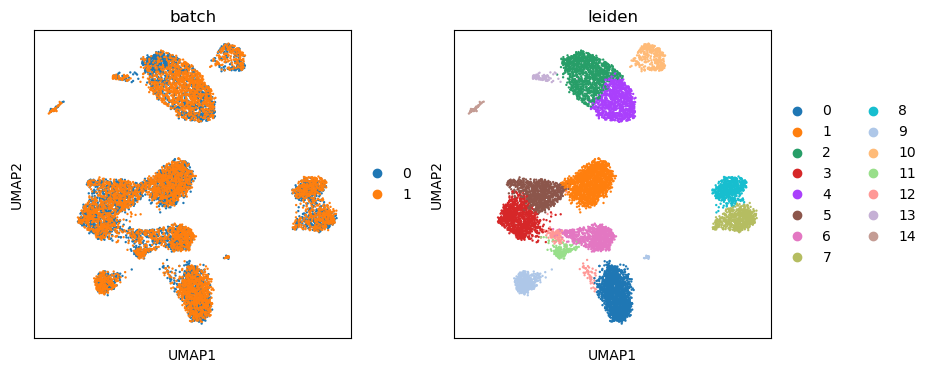

2025-01-31 14:17:57,104 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-31 14:17:59,626 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-31 14:17:59,683 - harmonypy - INFO - Iteration 1 of 20
2025-01-31 14:18:01,773 - harmonypy - INFO - Iteration 2 of 20
2025-01-31 14:18:03,847 - harmonypy - INFO - Iteration 3 of 20
2025-01-31 14:18:05,931 - harmonypy - INFO - Iteration 4 of 20
2025-01-31 14:18:07,166 - harmonypy - INFO - Iteration 5 of 20
2025-01-31 14:18:07,876 - harmonypy - INFO - Iteration 6 of 20
2025-01-31 14:18:08,592 - harmonypy - INFO - Converged after 6 iterations


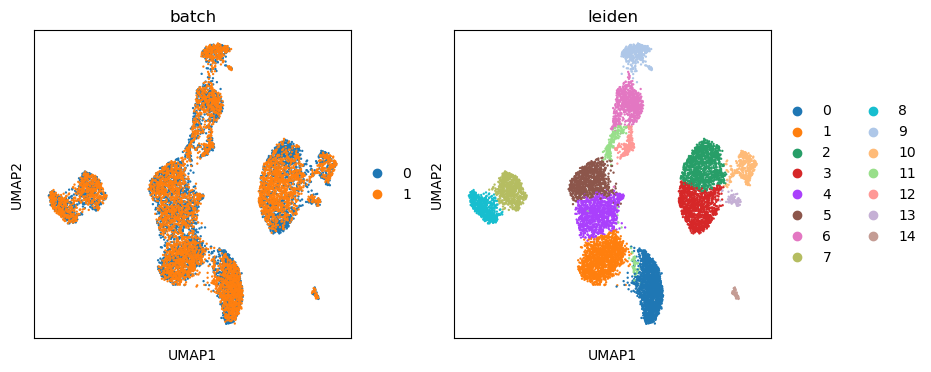

In [31]:
adata=AnnData(data_right)
gdata=AnnData(pd.DataFrame(generated_sample.detach().numpy()))
gdata.obs.index=adata.obs.index
gdata.var.index=adata.var.index
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color='leiden')
sc.tl.pca(gdata)
sc.pp.neighbors(gdata)
sc.tl.leiden(gdata)
sc.tl.umap(gdata)
sc.pl.umap(gdata,color='leiden')
cdata=adata.concatenate(gdata)
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata,color=['batch','leiden'])
sc.external.pp.harmony_integrate(cdata, 'batch',max_iter_harmony=20)
sc.pp.neighbors(cdata,n_pcs=20,n_neighbors=20,use_rep='X_pca_harmony')
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata,color=['batch','leiden'])